In [50]:
import pandas as pd
import zipfile

import scipy.stats as stats
import numpy as np
from collections import Counter

# Define the path to the zip file
zip_file_path = './papers_with_concepts_wo_title.csv.zip'

# read 'GDP_PPP_Data_EU.xlsx' into a DataFrame
gdp_ppp_data = pd.read_excel('GDP_PPP_Data_EU.xlsx')

EU_OLD = ['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'Sweden']
EU_NEW = ['Croatia', 'Cyprus', 'Czech Republic', 'Estonia', 'Hungary', 'Lithuania', 'Poland', 'Romania', 'Slovakia', 'Slovenia']
EU_14 = ['AT', 'BE', 'DE', 'DK', 'ES', 'FI', 'FR', 'GR', 'IE', 'IT', 'LU', 'NL', 'PT', 'SE']
EU_13 = ['CY', 'CZ', 'EE','HR', 'HU', 'LT', 'LV', 'PL', 'SI', 'SK', 'RO']


statistics = []
statistics_gdp = []
for year in range(2009, 2020):
    country_codes = []
    country_code_apc = {}
    apcs = []
    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # List all files in the zip
        csv_files = [file for file in z.namelist() if file.endswith('.csv')]
        if len(csv_files) != 1:
            raise ValueError('The zip file should contain exactly one CSV file')
        
        # Open the CSV file within the zip file
        with z.open(csv_files[0]) as f:
            # Read the CSV file line by line
            chunk_size = 1000  # Number of rows per chunk
            chunks = pd.read_csv(f, chunksize=chunk_size)

            # Process each chunk
            for chunk in chunks:
                # Process your chunk here
                # print(chunk.head())  # Example: print the first few rows of each chunk
                
                # get rows in chunk
                for index, row in chunk.iterrows():
                    if row['APC'] and row['publication_year'] == year:
                        country_codes.append(row['country_code'])
                        apcs.append(row['APC_in_dollar'])
                        if row['country_code'] in country_code_apc:
                            country_code_apc[row['country_code']] += row['APC_in_dollar']
                        else:
                            country_code_apc[row['country_code']] = row['APC_in_dollar']
    country_code_counter = Counter(country_codes)
    eu14 = []
    eu14_gdp = []
    for cc in EU_14:
        if cc in country_code_counter:
            #print(cc, country_code_apc[cc]/country_code_counter[cc])
            eu14.append(country_code_apc[cc]/country_code_counter[cc])
            #if cc in gdp_ppp_data['Country Code'].values:
            eu14_gdp.append(country_code_apc[cc]/country_code_counter[cc]/gdp_ppp_data[gdp_ppp_data['Country Code'] == cc][year].values[0])
    eu13= []
    eu13_gdp = []
    for cc in EU_13:
        if cc in country_code_counter:
            #print(cc, country_code_apc[cc]/country_code_counter[cc])
            eu13.append(country_code_apc[cc]/country_code_counter[cc])
            #if cc in gdp_ppp_data['Country Code'].values:
            eu13_gdp.append(country_code_apc[cc]/country_code_counter[cc]/gdp_ppp_data[gdp_ppp_data['Country Code'] == cc][year].values[0])

    mann_whitney_u_test = stats.mannwhitneyu(eu14, eu13, alternative='two-sided')
    mann_whitney_u_test_gdp = stats.mannwhitneyu(eu14_gdp, eu13_gdp, alternative='two-sided')
    statistics.append((year, np.mean(eu14), np.std(eu14), np.mean(eu13), np.std(eu13), mann_whitney_u_test))
    statistics_gdp.append((year, np.mean(eu14_gdp), np.std(eu14_gdp), np.mean(eu13_gdp), np.std(eu13_gdp), mann_whitney_u_test_gdp))
    print(statistics[-1])
    print(statistics_gdp[-1])
    

(2009, 1989.257587509357, 232.7832101369359, 1659.1118671432298, 383.0852560731, MannwhitneyuResult(statistic=106.0, pvalue=0.03764795382760189))
(2009, 0.05182377923670709, 0.008865928754118112, 0.07423933914238566, 0.01749925814684011, MannwhitneyuResult(statistic=9.0, pvalue=0.0003963274785936292))
(2010, 1984.6732204364157, 102.49052185410055, 1564.511592706972, 384.42999959435133, MannwhitneyuResult(statistic=116.0, pvalue=0.007717001420083896))
(2010, 0.05120143335292772, 0.010802500955370555, 0.06757877354774722, 0.018375950728900622, MannwhitneyuResult(statistic=32.0, pvalue=0.02810804014715179))
(2011, 2001.27181671757, 154.6665921185355, 1643.2722794970014, 340.5559011774707, MannwhitneyuResult(statistic=114.0, pvalue=0.010862255333717213))
(2011, 0.04997179335459323, 0.010773771245834883, 0.06628434496145005, 0.013669354959170404, MannwhitneyuResult(statistic=20.0, pvalue=0.0037504412848183765))
(2012, 1967.0466250269667, 120.85054467441824, 1774.2092088173274, 235.640567318

In [51]:
sts = []
for s in statistics:
    sts.append([s[0], s[1], s[2], s[3], s[4], s[5].statistic, s[5].pvalue])

sts_gdp = []
for s in statistics_gdp:
    sts_gdp.append([s[0], s[1], s[2], s[3], s[4], s[5].statistic, s[5].pvalue])

np.save('statistics.npy', sts)
np.save('statistics_gdp.npy', sts_gdp)

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.stats as stats

%matplotlib inline

import matplotlib
%config InlineBackend.figure_format='retina'

statistics = np.load('statistics.npy', allow_pickle=True)
statistics_gdp = np.load('statistics_gdp.npy', allow_pickle=True)

In [2]:
# convert statistics to a dataframe
df = pd.DataFrame(statistics, columns=['year', 'mean_EU14', 'std_EU14', 'mean_EU13', 'std_EU13', 'U', 'p-value'])
df_gdp = pd.DataFrame(statistics_gdp, columns=['year', 'mean_EU14', 'std_EU14', 'mean_EU13', 'std_EU13', 'U', 'p-value'])

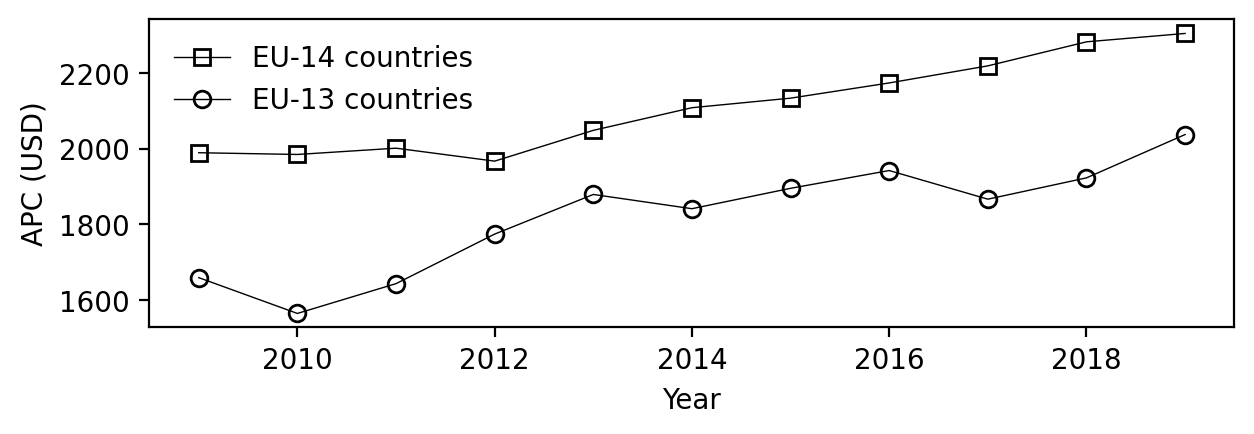

In [92]:
# get mean_EU14 and mean_EU13
mean_EU14 = df['mean_EU14']
mean_EU13 = df['mean_EU13']

# x-axis year
year = df['year']


plt.figure(figsize=(7, 2))
plt.plot(year,mean_EU14,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="EU-14 countries")
plt.plot(year,mean_EU13,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="EU-13 countries")
plt.xlabel('Year')
plt.ylabel('APC (USD)')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='upper left')
#plt.ylim(0.09,0.51)

In [36]:
mean_EU_OLD = np.load('rho_mean_EU_OLD.npy', allow_pickle=True)
mean_EU_NEW = np.load('rho_mean_EU_NEW.npy', allow_pickle=True)

(0.09, 0.51)

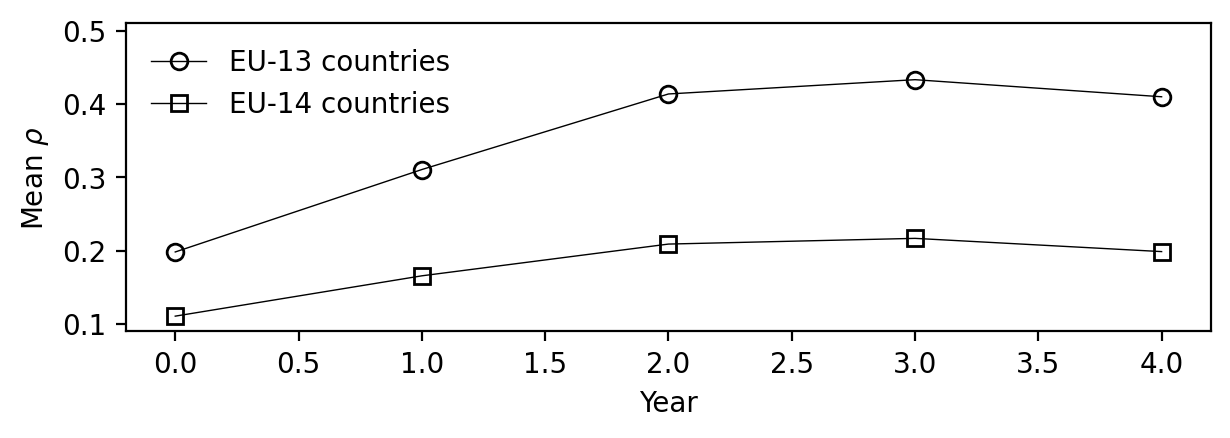

In [6]:
plt.figure(figsize=(7, 2))
plt.plot(mean_EU_NEW,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="EU-13 countries")
plt.plot(mean_EU_OLD,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="EU-14 countries")
plt.xlabel('Year')
plt.ylabel(r'Mean $\rho$')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='upper left')
plt.ylim(0.09,0.51)

In [7]:
# read excel file into a DataFrame
apcs = pd.read_excel('APCdataset-2019-2023.xlsx')

In [9]:
# get unique publishers
publishers = apcs['Publisher'].unique()

In [117]:
# get mean APC for each publisher
years = np.arange(2019, 2024)
apc_eu_new = []
apc_eu_old = []
big3_apc = []
mdpi_apc = []
for i in range(5):
    yr = years[i]
    mean_APC = apcs.groupby('Publisher')['APC_USD-'+str(yr)].mean()
    gold = apcs[(apcs['OA status'] == 'Gold') | (apcs['OA status'] == 'Gold')]
    mean_APC_gold = gold.groupby('Publisher')['APC_USD-'+str(yr)].mean()
    mean_Big3 = mean_APC[['Elsevier', 'Springer Nature', 'Wiley']]
    mean_Big3 = mean_Big3.mean()
    mean_Big3_gold = mean_APC_gold[['Elsevier', 'Springer Nature', 'Wiley']]
    mean_Big3_gold = mean_Big3_gold.mean()
    mean_Big3_gold = 0.5*(mean_Big3_gold + mean_Big3)
    apcnew, apcold = mean_EU_NEW[i]*mean_APC['MDPI'] + (1-mean_EU_NEW[i])*mean_Big3, mean_EU_OLD[i]*mean_APC['MDPI'] + (1-mean_EU_OLD[i])*mean_Big3
    #apcnew_gold, apcold_gold = mean_EU_NEW[i]*mean_APC_gold['MDPI'] + (1-mean_EU_NEW[i])*mean_Big3_gold, mean_EU_OLD[i]*mean_APC_gold['MDPI'] + (1-mean_EU_OLD[i])*mean_Big3_gold
    apcnew_gold, apcold_gold = mean_EU_NEW[i]*mean_APC_gold['MDPI'] + (1-mean_EU_NEW[i])*mean_Big3_gold, mean_EU_OLD[i]*mean_APC_gold['MDPI'] + (1-mean_EU_OLD[i])*mean_Big3_gold

    print(i,yr, apcnew, apcold, mean_Big3, mean_APC['MDPI'], mean_Big3_gold, mean_APC_gold['MDPI'], apcnew_gold, apcold_gold)
    apc_eu_new.append(apcnew)
    apc_eu_old.append(apcold)
    big3_apc.append(mean_Big3)
    mdpi_apc.append(mean_APC['MDPI'])


0 2019 2448.696320684374 2594.2318110027672 2778.6047388798615 1115.5918083333333 2395.996125728486 1115.5918083333333 2141.9895842016645 2254.0417918033527
1 2020 2331.7972057480006 2563.0961549944564 2827.791678761218 1231.8235235955055 2442.832305906204 1231.8235235955055 2066.475383712975 2241.983308460766
2 2021 2336.6994252494615 2654.000993792795 2978.211249094303 1428.0167710445683 2582.8559258828163 1428.0167710445683 2104.9526802205314 2341.330941421948
3 2022 2370.2380623037484 2734.936555909463 3100.554684983433 1415.1404768055556 2652.714298378424 1415.1404768055556 2116.4539955386726 2384.2465098437724
4 2023 2462.8098276248384 2792.1776955552778 3102.438766655226 1542.42168204067 2613.205959356227 1542.42168204067 2174.169350087942 2400.245037278253


In [75]:
mean_APC

Publisher
Elsevier                    2936.365237
Elsevier>Springer Nature    2851.666667
Elsevier>Wiley              2802.500000
Frontiers                   2096.244344
MDPI                        1542.421682
PLOS                        2995.000000
Springer Nature             3293.215254
Springer Nature>Wiley       3178.571429
Wiley                       3077.735809
Name: APC_USD-2023, dtype: float64

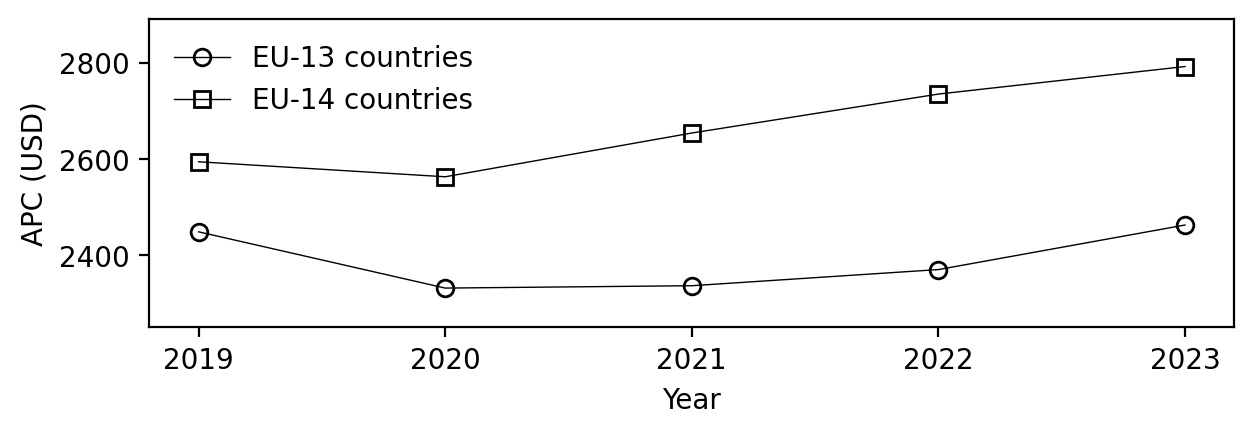

In [49]:
plt.figure(figsize=(7, 2))
plt.plot(years,apc_eu_new,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="EU-13 countries")
plt.plot(years,apc_eu_old,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="EU-14 countries")
plt.xlabel('Year')
plt.ylabel('APC (USD)')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='upper left')
plt.ylim(2250,2890)
# plot x labels at 2019, 2020, 2021, 2022, 2023
plt.xticks(years);

In [50]:
country_mean_fmdpi = pd.read_excel('country_mean_fmdpi.xlsx')

In [53]:
EU_OLD = ['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'Sweden']
EU_NEW = ['Croatia', 'Cyprus', 'Czech Republic', 'Estonia', 'Hungary', 'Lithuania', 'Poland', 'Romania', 'Slovakia', 'Slovenia']

In [155]:
years = np.arange(2019, 2024)
apc_eu_new = []
apc_eu_old = []
p_values = []
for i in range(5):
    yr = years[i]
    mean_APC = apcs.groupby('Publisher')['APC_USD-'+str(yr)].mean()
    mean_Big3 = mean_APC[['Elsevier', 'Springer Nature', 'Wiley']]
    mean_Big3 = mean_Big3.mean()

    gold = apcs[(apcs['OA status'] == 'Gold') | (apcs['OA status'] == 'Hybrid>Gold')]
    hyb = apcs[(apcs['OA status'] == 'Hybrid')]
    mean_APC_gold = gold.groupby('Publisher')['APC_USD-'+str(yr)].mean()
    mean_Big3_hyb = hyb.groupby('Publisher')['APC_USD-'+str(yr)].mean()
    mean_Big3_gold = mean_APC_gold[['Elsevier', 'Springer Nature', 'Wiley']]
    mean_Big3_hyb = mean_Big3_hyb[['Elsevier', 'Springer Nature', 'Wiley']]
    mean_Big3_gold = mean_Big3_gold.mean()
    mean_Big3_hyb = mean_Big3_hyb.mean()

    #apcnew, apcold = mean_EU_NEW[i]*mean_APC['MDPI'] + (1-mean_EU_NEW[i])*mean_Big3, mean_EU_OLD[i]*mean_APC['MDPI'] + (1-mean_EU_OLD[i])*mean_Big3
    #apcnew_gold, apcold_gold = mean_EU_NEW[i]*mean_APC_gold['MDPI'] + (1-mean_EU_NEW[i])*mean_Big3_gold, mean_EU_OLD[i]*mean_APC_gold['MDPI'] + (1-mean_EU_OLD[i])*mean_Big3_gold

    mean_Big3_gold = 0.95*mean_Big3_gold + 0.05*mean_Big3_hyb
    #apc_new = (country_mean_fmdpi.loc[i,EU_NEW]*mean_APC['MDPI'] + (1-country_mean_fmdpi.loc[i,EU_NEW])*mean_Big3).values
    apc_new = (country_mean_fmdpi.loc[i,EU_NEW]*mean_APC_gold['MDPI'] + (1-country_mean_fmdpi.loc[i,EU_NEW])*mean_Big3_gold).values
    apc_eu_new.append(np.mean(apc_new))
    
    mean_Big3_gold = 0.65*mean_Big3_gold + 0.35*mean_Big3_hyb
    #apc_old = (country_mean_fmdpi.loc[i,EU_OLD]*mean_APC['MDPI'] + (1-country_mean_fmdpi.loc[i,EU_OLD])*mean_Big3).values
    apc_old = (country_mean_fmdpi.loc[i,EU_OLD]*mean_APC_gold['MDPI'] + (1-country_mean_fmdpi.loc[i,EU_OLD])*mean_Big3_gold).values

    apc_eu_old.append(np.mean(apc_old))
    
    mann_whitney_u_test = stats.mannwhitneyu(apc_new, apc_old, alternative='two-sided')
    p_values.append(mann_whitney_u_test.pvalue)


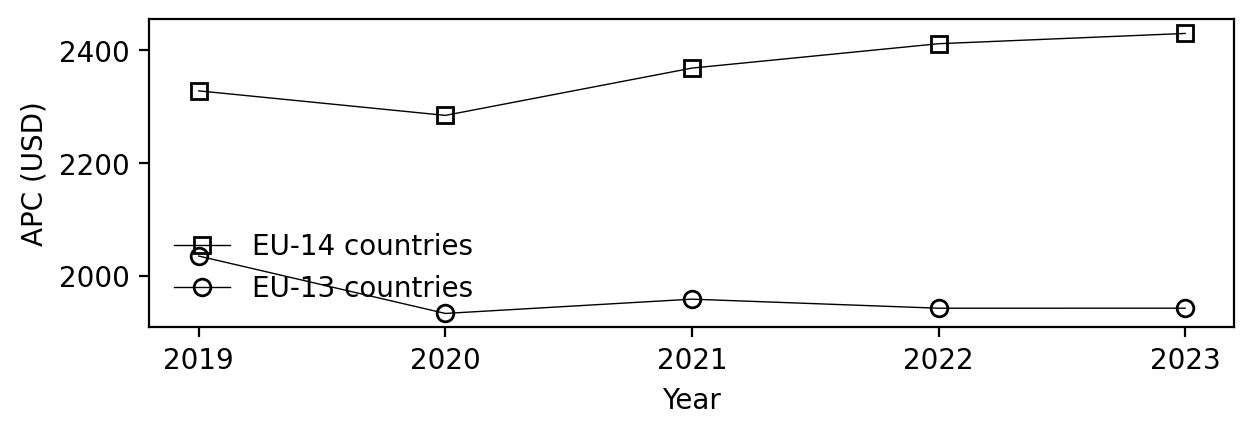

In [156]:
plt.figure(figsize=(7, 2))
plt.plot(years,apc_eu_old,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="EU-14 countries")
plt.plot(years,apc_eu_new,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="EU-13 countries")
plt.xlabel('Year')
plt.ylabel('APC (USD)')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='lower left')
#plt.ylim(2250,2890)
# plot x labels at 2019, 2020, 2021, 2022, 2023
plt.xticks(years);

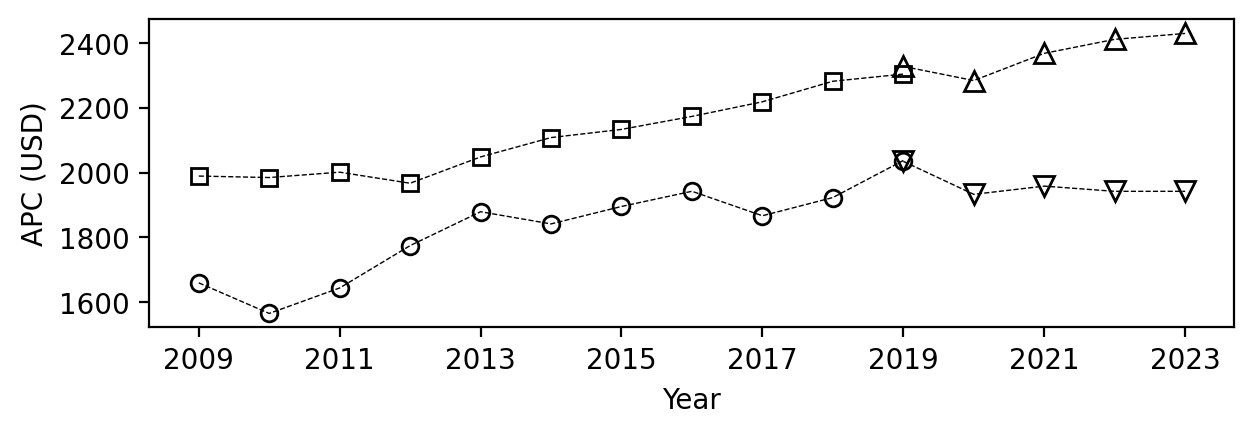

In [162]:
# get mean_EU14 and mean_EU13
mean_EU14 = df['mean_EU14']
mean_EU13 = df['mean_EU13']

# x-axis year
year = df['year']


plt.figure(figsize=(7, 2))
plt.plot(year,mean_EU14,marker='s',color="black",ms=6, ls='--', mfc='none',lw=0.5, label="EU-14 countries")
plt.plot(year,mean_EU13,marker='.',color="black",ms=12, ls='--', mfc='none',lw=0.5, label="EU-13 countries")
plt.plot(years,apc_eu_old,marker='^',color="black",ms=7, ls='--', mfc='none',lw=0.5)
plt.plot(years,apc_eu_new,marker='v',color="black",ms=7, ls='--', mfc='none',lw=0.5)
plt.xlabel('Year')
plt.ylabel('APC (USD)')
# plot legend without frame, place it in the upper left corner
#plt.legend(frameon=False, loc='upper left')
#plt.ylim(0.09,0.51)
# plot vertical lines at 2019
#plt.axvline(x=2019, color='black', linestyle='--', lw=0.5)
# x labels at 2010 to 2023
plt.xticks(np.arange(2009, 2024, 2));


In [158]:
apc_eu_old

[2328.1823535933668,
 2284.606593946005,
 2368.6133445631435,
 2411.916218625525,
 2430.165146082923]

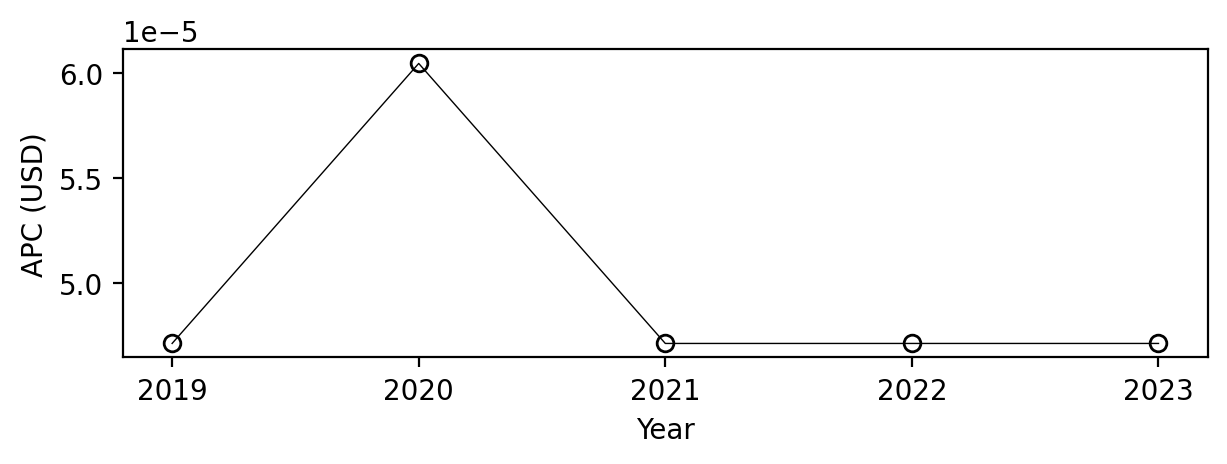

In [159]:
plt.figure(figsize=(7, 2))
plt.plot(years,p_values,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="EU-13 countries")
#plt.plot(years,apc_eu_old,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="EU-14 countries")
plt.xlabel('Year')
plt.ylabel('APC (USD)')
# plot legend without frame, place it in the upper left corner
#plt.legend(frameon=False, loc='upper left')
#plt.ylim(2250,2890)
# plot x labels at 2019, 2020, 2021, 2022, 2023
plt.xticks(years);

In [149]:
p_values

[4.711347153516134e-05,
 6.047509713585352e-05,
 4.711347153516134e-05,
 4.711347153516134e-05,
 4.711347153516134e-05]

In [26]:
mean_EU_NEW[1]*mean_APC['MDPI'] + (1-mean_EU_NEW[1])*mean_Big3, mean_EU13.to_list()[-1]

(2331.7972057480006, 2037.3447123443416)

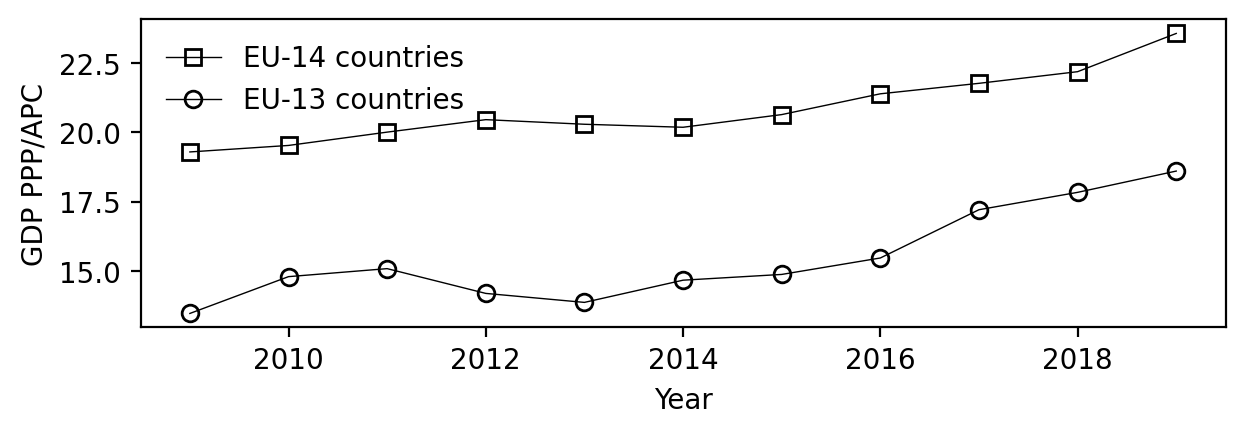

In [20]:
# get mean_EU14 and mean_EU13
mean_EU14 = df_gdp['mean_EU14']
mean_EU13 = df_gdp['mean_EU13']

# x-axis year
year = df['year']


plt.figure(figsize=(7, 2))
plt.plot(year,1/mean_EU14,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="EU-14 countries")
plt.plot(year,1/mean_EU13,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="EU-13 countries")
plt.xlabel('Year')
plt.ylabel('GDP PPP/APC')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='upper left')
#plt.ylim(0.09,0.51)

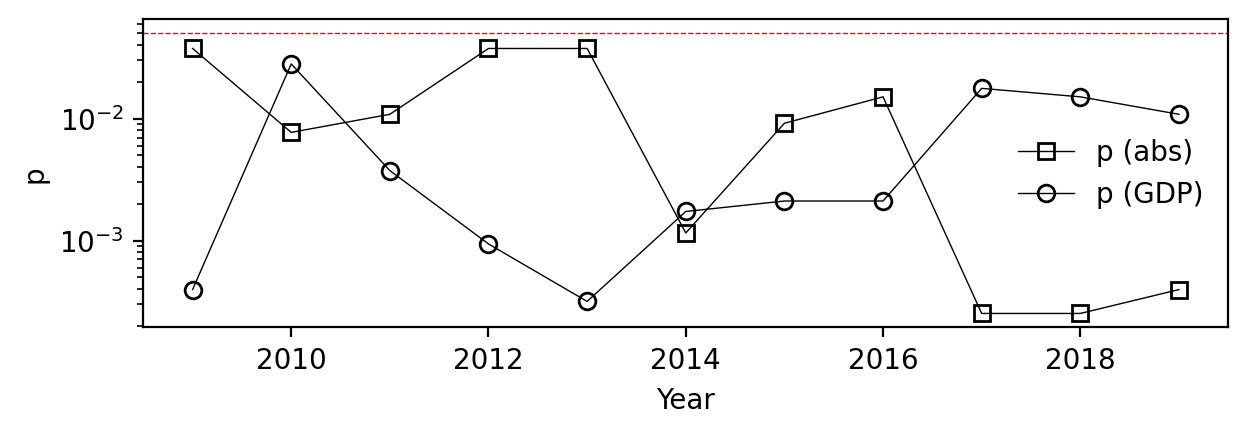

In [160]:
# get mean_EU14 and mean_EU13
p_value = df['p-value']
p_value_gdp = df_gdp['p-value']


# x-axis year
year = df['year']


plt.figure(figsize=(7, 2))
plt.plot(year,p_value,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="p (abs)")
plt.plot(year,p_value_gdp,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="p (GDP)")
plt.xlabel('Year')
plt.ylabel('p')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='best')
#plt.ylim(0.09,0.51)
plt.yscale('log')
# plot horizontal line at y=0.05
plt.axhline(y=0.05, color='r', linestyle='--',lw=0.5)

In [161]:
p_value

0     0.037648
1     0.007717
2     0.010862
3     0.037648
4     0.037648
5     0.001155
6     0.009170
7     0.015099
8     0.000253
9     0.000253
10    0.000396
Name: p-value, dtype: float64